In [ ]:
#| default_exp t2s_up_wds_mlang_enclm
%load_ext autoreload
%autoreload 2

In [ ]:
#| exporti
import dataclasses
import random
import math
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.profiler import record_function

from huggingface_hub import hf_hub_download
from fastcore.basics import store_attr
from fastprogress import progress_bar

from pathlib import Path

In [ ]:
#| exporti
from whisperspeech.modules import *
from whisperspeech import languages, inference

In [ ]:
from whisperspeech.wer_metrics import *
from whisperspeech.train import *

from fastprogress import master_bar
import webdataset as wds

# Text to semantic tokens model

Multi-GPU training example:

    python3 -m whisperspeech.train_multi \
        --task "t2s_up_wds base --frozen_embeddings_model vqmodel-256c-dim64-4e-hyptuned-32gpu.model" \
        --input-dir "whisperspeech-t2s-512c-dim64/*.tar.gz 600000 --vq_codes=513"
        --batch-size 32 --epochs 1 \
        --tunables=--cps_input

# Dataset

In [ ]:
#| exporti
import re

class CharTokenizer:
    """Trivial tokenizer – just use UTF-8 bytes"""
    eot = 0
    
    def encode(self, txt):
        return list(bytes(txt.strip(), 'utf-8'))

    def decode(self, tokens):
        return bytes(tokens).decode('utf-8')
    
def tokenizer(ikey, okey, length):
    """Tokenizes a transcript"""
    tok = CharTokenizer()
    def _tokenizer(samples):
        for s in samples:
            toks = torch.tensor(tok.encode(s[ikey]))
            s[okey] = F.pad(toks, (0, length - toks.shape[-1]), value=tok.eot)
            yield s
    return _tokenizer

def ar_padder(ikey, okey, length, pad_token):
    """Pads the tokens for autoregresive training"""
    import numpy as np

    def _ar_padder(samples):
        for s in samples:
            toks = s[ikey]
            if isinstance(toks, (list, np.ndarray)): toks = torch.tensor(toks)
            toks = toks.to(torch.long)
            s['in_' +okey] = F.pad(toks, (1, length - toks.shape[-1] - 1), value=pad_token)
            s['out_'+okey] = F.pad(toks, (0, length - toks.shape[-1]), value=pad_token)
            yield s
    return _ar_padder

def char_per_seconder(txt_key, stoks_key, cps_key, stoks_per_second=25):
    """Adds the characters per second metric to the input data"""
    def _char_per_seconder(samples):
        for s in samples:
            secs = s[stoks_key].shape[-1] / stoks_per_second
            s[cps_key] = len(s[txt_key]) / secs
            yield s
    return _char_per_seconder

In [ ]:
#| export
def load_dataset(
    dataset_dir:Path,
    stoks_dir:str=None,
    txt_dir:str=None,
    vq_codes:int=4096,
    weight:float=1,
    validation:bool=False,
    exclude_datasets:str="txt-random-valid",
):
    import webdataset as wds
    from whisperspeech import utils, languages

    dataset_dir = Path(dataset_dir)
    
    if txt_dir is None:
        for name in ['small.en-txt', 'medium-txt']:
            if (dataset_dir/name).exists():
                txt_dir = name
                break
    assert txt_dir is not None, f"No transcripts found in {dataset_dir}"

    txt_path = dataset_dir/f'{txt_dir}/*.tar.gz'
    shards = utils.shard_glob(txt_path)
    assert len(shards), f"No data shards found in {txt_path}."

    with open(dataset_dir/'txt-samples.list') as f: samples = len(f.readlines())
    language = utils.readlines(dataset_dir/'language')[0]
    language = languages.to_id(language)
    
    excludes = {x
                for dir in exclude_datasets.split()
                for x in utils.readlines(dataset_dir/Path(dir)/"txt-samples.list")
               } if not validation and exclude_datasets else set()

    def set_language(x):
        x['language'] = language
        return x
    
    same_on_all_nodes = lambda urls: urls # will only be used for validation
    ds = wds.WebDataset(shards, resampled=not validation, nodesplitter=same_on_all_nodes).compose(
        wds.decode(),
        utils.merge_in(utils.derived_dataset(stoks_dir)),
        wds.select(lambda s: s['__key__'] not in excludes and len(s['stoks.npy']) > 0), # discard validation samples
        tokenizer('txt', 'ttoks', length=550),
        ar_padder('stoks.npy', 'stoks', length=750, pad_token=vq_codes-1),
        ar_padder('ttoks', 'ttoks', length=550, pad_token=CharTokenizer.eot),
        char_per_seconder('txt', 'stoks.npy', 'cps', stoks_per_second=25),
        wds.map(set_language),
        wds.to_tuple('in_ttoks', 'out_ttoks', 'language', 'cps', 'in_stoks', 'out_stoks'),
    )
    if validation:
        ds = ds.compose(
            wds.batched(samples)
        ).slice(1)
    else:
        ds = ds.compose(
            wds.shuffle(20000, initial=20000),
            wds.batched(2048)
        )
    ds.total_samples = samples
    ds.stoks_len = 750
    ds.stoks_codes = vq_codes
    ds.ttoks_len = 550
    ds.weight = weight

    return ds

In [ ]:
%pdb

Automatic pdb calling has been turned ON


In [ ]:
train_ds = load_dataset('../wolnelektury-wds2/wolnelektury-medium-txt-*.tar.gz', '../wolnelektury-vqv2/', 190000,
                        txt_kind='medium-txt', vq_codes=513, language='pl',
                        exclude_files='../wolnelektury-wds2/validation-samples')
val_ds = load_dataset('../wolnelektury-wds2/validation-eqvad.tar.gz', '../wolnelektury-vqv2/', 520,
                      txt_kind='medium-txt', vq_codes=513, language='pl', validation=True)

In [ ]:
for x in progress_bar(train_ds, total=100): pass
x

[tensor([[  0,  80, 114,  ...,   0,   0,   0],
         [  0,  74,  97,  ...,   0,   0,   0],
         [  0,  80, 114,  ...,   0,   0,   0],
         ...,
         [  0,  90,  32,  ...,   0,   0,   0],
         [  0,  78, 105,  ...,   0,   0,   0],
         [  0,  74,  97,  ...,   0,   0,   0]]),
 tensor([[ 80, 114, 111,  ...,   0,   0,   0],
         [ 74,  97,  99,  ...,   0,   0,   0],
         [ 80, 114, 111,  ...,   0,   0,   0],
         ...,
         [ 90,  32, 100,  ...,   0,   0,   0],
         [ 78, 105, 101,  ...,   0,   0,   0],
         [ 74,  97,  32,  ...,   0,   0,   0]]),
 array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]),
 array([16.87227866, 13.26666667, 10.44474394, 12.30366492, 17.85714286,
        12.91291291, 17.57731959, 12.5904

# Modeling

In [ ]:
#| export
def rand(start, end):
    return random.random() * (end - start) + start

@dataclasses.dataclass
class Tunables:
    init_std :float = 1
    embeddings_std :float = .01
    embeddings_lr_scale: float = 5
    embedding_projector_lr_scale: float = 2.5
    output_mult :float = .35
    query_mult :float = 1
    encoder_depth_ratio :float = 0.25
    causal_encoder: bool = True
    eot_dropout_p :float = .5
    cps_input: bool = True
    cps_bins: int = 32
    padding_token_offset: int = 0
        
    lr0 :float = 1.5e-3
    clip_gradient_norm :float = .2
    weight_decay :float = 1e-1
    warmup_steps :float = 4000

    random :bool = False

    def __post_init__(self):
        # randomize the hyperparams if requested
        if self.random:
            self.init_std = 10**rand(-1,1)
            self.embeddings_std = 10**rand(-3,-.7)
            self.embeddings_lr_scale = rand(2,6)
            self.output_mult = rand(0.25,0.65)
            self.query_mult = 2**rand(-2,3)
            self.encoder_depth_ratio = 0.25
            
            self.lr0 = rand(1,5)*1e-3
            self.clip_gradient_norm = 10**rand(-3,0)
            self.warmup_steps = 100*(10**rand(1,1.85))

    @staticmethod
    def upgrade(args):
        args = {k:v for k,v in args.items()}
        def old_default(name, value):
            if name not in args: args[name] = value
        old_default('padding_token_offset', -1)
        return args

In [ ]:
#| export
class T2SEmbedding(nn.Module):
    def __init__(self, length=1500, codes=1024, width=384, pos_embs=None, stoks_width=384):
        super().__init__()
        self.embedding = FlexEmbeddings(codes, width, special_codes=1, frozen_width=stoks_width)
        if pos_embs is None: pos_embs = sinusoids(length, width)
        self.register_buffer("positional_embedding", pos_embs)
    
    def forward(self, Stoks, xenc, cps=None, offset=0):
        Sembs = self.embedding(Stoks)
        xin = (Sembs + self.positional_embedding[offset : offset + Sembs.shape[1]]).to(xenc.dtype)
        if cps is not None: xin = xin + cps
        return xin, offset

In [ ]:
#| export
class Encoder(nn.Module):
    def __init__(self, depth=6, width=384, n_head=6, length=1500, codes=1024, emb_width=384, ffn_mult=4, pos_embs=None, tunables=Tunables()):
        super().__init__()
        self.emb_width = emb_width
        self.tunables = tunables
        
        self.embedding = FlexEmbeddings(codes, width, frozen_width=emb_width)

        if pos_embs is None: pos_embs = sinusoids(length, width)
        self.register_buffer("positional_embedding", pos_embs)

        self.layers = nn.ModuleList([
            ResidualAttentionBlock(width, n_head,
                                   qk_scale=tunables.query_mult*8/math.sqrt(width/n_head), ffn_mult=ffn_mult) for _ in range(depth)
        ])

        self.ln_post = LayerNorm(width)
        
        mask = torch.empty(length, length).fill_(-torch.inf).triu_(1)
        self.register_buffer("mask", mask, persistent=False)
        
    def forward(self, Stoks, positions, lang_emb=None):
        xin = self.embedding(Stoks)

        if lang_emb is not None: xin = xin + lang_emb
        
        x = (xin +
             self.positional_embedding[positions]).to(xin.dtype)

        for l in self.layers: x = l(x, positions,
                                    causal=self.tunables.causal_encoder and self.training,
                                    mask=self.mask if self.tunables.causal_encoder and not self.training else None)
        
        return self.ln_post(x)

In [ ]:
#| export
class TSARTransformer(nn.Module):
    def __init__(self, depth=6, n_head=6, head_width=64, ffn_mult=4,
                 ttoks_len=200, ttoks_codes=256, ttoks_width=None,
                 stoks_len=1500, stoks_codes=1024, stoks_width=None,
                 tunables=Tunables()):
        super().__init__()
        store_attr("depth,n_head,head_width,ffn_mult,stoks_width,ttoks_width,ttoks_len,stoks_len,ttoks_codes,stoks_codes")

        width = n_head * head_width
        self.width = width
        self.base_width = 3 * head_width
        self.tunables = tunables
        if self.stoks_width is None: self.stoks_width = self.width
        if self.ttoks_width is None: self.ttoks_width = self.width
        
        self.lang_embeddings = nn.Embedding(len(languages.languages), width)
        if tunables.cps_input:
            self.cps_embeddings = nn.Embedding(tunables.cps_bins, self.width)
        else:
            self.cps_embeddings = None        
        
        encoder_depth = int(depth * 2 * tunables.encoder_depth_ratio)
        decoder_depth = depth * 2 - encoder_depth
        tformer_args = dict(width=width, n_head=n_head, ffn_mult=ffn_mult, tunables=tunables)
        self.encoder = Encoder(length=ttoks_len, codes=ttoks_codes, emb_width=self.ttoks_width, depth=encoder_depth, **tformer_args)
        self.embeddings = T2SEmbedding(length=stoks_len, codes=stoks_codes, width=width, stoks_width=self.stoks_width)

        self.decoder = BaseDecoder(
            length=stoks_len, 
            depth=decoder_depth,
            qk_scale=tunables.query_mult*8/math.sqrt(width/n_head),
            width=width, n_head=n_head, ffn_mult=ffn_mult,
        )
        self.tokenizer = None
        
        self.apply(self.init_transformer)

    def load_frozen_semantic_embeddings(self, vqmodel):
        self.embeddings.embedding.set_frozen_embeddings(vqmodel.rq.layers[0]._codebook.embed[0])

    def setup(self, device):
        pass

    def init_transformer(self, m):
        if isinstance(m, LinearHead):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, QueryHead):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, nn.Embedding):
            m.no_weight_decay = True
            m.lr_scale = self.tunables.embeddings_lr_scale
            std = self.tunables.embeddings_std
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
        elif isinstance(m, EmbeddingProjector):
            m.lr_scale = self.tunables.embedding_projector_lr_scale
            std = self.tunables.init_std
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.Linear):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            std = self.tunables.init_std / m.weight.shape[1]
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
            if m.bias is not None:
                torch.nn.init.trunc_normal_(m.bias, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.LayerNorm):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.bias, 0)
            torch.nn.init.constant_(m.weight, 1)
    
    def _embed_cps(self, cpss):
        if self.cps_embeddings is None: return None

        cps_bin = (cpss / 20 * self.tunables.cps_bins).to(torch.long)
        cps_bin[cps_bin >= self.tunables.cps_bins] = self.tunables.cps_bins-1
        return self.cps_embeddings(cps_bin).unsqueeze(1)

    def run_encoder(self, in_ttoks, languages, cpss):
        if len(languages.shape) != 3: lang_embs = self.lang_embeddings(languages)
        else: lang_embs = languages
        if len(lang_embs.shape) == 2: lang_embs = lang_embs.unsqueeze(1)
        
        cps_emb = self._embed_cps(cpss)

        with record_function("encoder"):
            positions = torch.arange(0, in_ttoks.shape[1], device=in_ttoks.device)
            xenc = self.encoder(in_ttoks.to(torch.long), positions, lang_emb=lang_embs)

        return xenc, positions, cps_emb
    
    def forward(self, in_ttoks, out_ttoks, languages, cpss, in_stoks, out_stoks=None, in_stoks_positions=None, loss=True, offset=None, xenc=None, xenc_positions=None, cps_emb=None):
        if xenc is None:
            xenc, xenc_positions, cps_emb = self.run_encoder(in_ttoks, languages, cpss)

        with record_function("decoder"):
            x = (self.embeddings.embedding(in_stoks) + 
                 self.embeddings.positional_embedding[in_stoks_positions] +
                 cps_emb).to(xenc[0].dtype)
            x = self.decoder(x, in_stoks_positions, xenc.clone(), xenc_positions)
            logits = self.embeddings.embedding.unembed(x)
            logits = logits * self.tunables.output_mult / (self.width / self.base_width)

        if loss is not None:
            with record_function("loss"):
                loss = F.cross_entropy(logits.transpose(-1,-2), out_stoks)
                if self.training and self.tunables.causal_encoder:
                    enc_logits = self.encoder.embedding.unembed(xenc)
                    enc_logits = enc_logits * self.tunables.output_mult / (self.width / self.base_width)
                    loss += 0.1 * F.cross_entropy(enc_logits.transpose(-1,-2), out_ttoks)

        return logits, loss

    #
    # inference
    #
    @classmethod
    def load_model(cls, ref="collabora/whisperspeech:t2s-small-en+pl.model",
                   repo_id=None, filename=None, local_filename=None, spec=None, device=None):
        if repo_id is None and filename is None and local_filename is None and spec is None:
            if ":" in ref:
                repo_id, filename = ref.split(":", 1)
            else:
                local_filename = ref
        if not local_filename and spec is None:
            local_filename = hf_hub_download(repo_id=repo_id, filename=filename)
        if spec is None:
            spec = torch.load(local_filename, map_location=device)
        model = cls(**spec['config'], tunables=Tunables(**Tunables.upgrade(spec['tunables'])))
        model.load_state_dict(spec['state_dict'])
        model.eval().to(device)
        return model

    def load_checkpoint(self, local_filename_or_obj):
        if isinstance(local_filename_or_obj, (str, Path)):
            spec = torch.load(local_filename, map_location='cpu')
        else:
            spec = local_filename_or_obj
        assert 'pytorch-lightning_version' in spec, 'not a valid PyTorch Lightning checkpoint'
        state_dict = {k.replace('model.', ''):v
                      for k,v in spec['state_dict'].items()}
        self.load_state_dict(state_dict)
        return self

    def save_model(self, fname):
        torch.save(dict(config = self.__stored_args__,
                        tunables = dataclasses.asdict(self.tunables),
                        state_dict = self.state_dict()), fname)

    def ensure_tokenizer(self):
        assert not self.training
        if self.tokenizer is None: self.tokenizer = CharTokenizer()

    def switch_dtypes(self, dtype=torch.float16):
        self.dtype = dtype
        for n,m in self.named_modules():
            # convert every leaf layer apart from the LayerNorms
            if isinstance(m, (nn.Linear, nn.Embedding)):
                m.to(dtype)
            # take care of buffers ([kv]_cache, masks) that are not in the leaf layers
            for bn,b in m.named_buffers(recurse=False):
                setattr(m,bn,b.to(dtype))

    def optimize(self, max_batch_size=1, dtype=torch.float16, torch_compile=True):
        for emb in [self.embeddings.embedding, self.embeddings.embedding]:
            emb.convert_for_eval()
        for l in self.encoder.layers:
            l.attn.convert_for_eval()
        for l in self.decoder.layers:
            l.attn.convert_for_eval()
            l.cross_attn.convert_for_eval()
            l.setup_kv_cache(max_batch_size, self.stoks_len, self.ttoks_len)
        self.switch_dtypes(dtype)
        if torch_compile:
            self.generate_next = torch.compile(self.generate_next, mode="reduce-overhead", fullgraph=True)
            
    def optimize_training(self):
        # breaks with: Error: accessing tensor output of CUDAGraphs that has been overwritten by a subsequent run.
        # somewhere inside LayerNorm???
        self.encoder = torch.compile(self.encoder, fullgraph=True, mode="reduce-overhead")
        self.decoder = torch.compile(self.decoder, fullgraph=True, mode="reduce-overhead")

    @property
    def device(self):
        return next(self.parameters()).device

    def generate_one(self, toks, toks_positions, cps_emb, xenc, xenc_positions, T, top_k):
        probs, _ = self(None, None, None, None, toks, in_stoks_positions=toks_positions, loss=None, xenc=xenc, xenc_positions=xenc_positions, cps_emb=cps_emb)
        probs = probs[:,-1]
        probs[self.embeddings.embedding.codes:] = -torch.inf
        return inference.sample(probs, T, top_k)

    def generate_next(self, *args, **kwargs):
        return self.generate_one(*args, **kwargs)

    @torch.no_grad()
    def prep(self, txt, cps=15, lang="en"):
        dev = self.device
        ttoks = torch.tensor(self.tokenizer.encode(txt), device=dev)
        ttoks = F.pad(ttoks, (0, self.ttoks_len - len(ttoks)), value=self.tokenizer.eot).unsqueeze(0)
        cpss = torch.tensor([cps], device=dev)
        langs = torch.tensor([languages.to_id(lang)], device=dev)
        return ttoks, cpss, langs
    
    @torch.no_grad()
    def generate(self, txt, cps=15, lang="en", stoks_prompt=None, N=None, bs=1, T=0.7, top_k=None, step=None, show_progress_bar=True):
        self.ensure_tokenizer()
        N = N or self.stoks_len
        dev = self.device
        ttoks = []
        langs = []
        if isinstance(lang, list):
            lang0 = lang[0]
            assert isinstance(txt, list), "lang and txt have to be both lists or strings"
            for txt, lang in zip(txt, lang):
                tt = self.tokenizer.encode(txt)
                ttoks += tt
                langs += [languages.to_id(lang)] * len(tt)
        elif isinstance(lang, torch.Tensor):
            langs = lang
            ttoks = self.tokenizer.encode(txt)
        else:
            lang0 = lang
            ttoks = self.tokenizer.encode(txt)
            langs = torch.tensor([languages.to_id(lang)], device=dev)
        ttoks = torch.tensor(ttoks, device=dev)
        ttoks = F.pad(ttoks, (1, self.ttoks_len - len(ttoks) - 1), value=self.tokenizer.eot)
        cpss = torch.tensor([cps], device=dev)
        T = torch.tensor(T, device=dev)
        if not isinstance(langs, torch.Tensor):
            langs = torch.tensor(langs, device=dev)
            langs = F.pad(langs, (1, self.ttoks_len - len(langs) - 1), value=languages.to_id(lang0))

        toks = torch.zeros((bs,N), dtype=torch.long, device=dev)
        toks[:,0] = self.stoks_codes + self.tunables.padding_token_offset
        start = 0
        if stoks_prompt is not None:
            toks[:,1:len(stoks_prompt)+1] = stoks_prompt
            start = len(stoks_prompt)
        it = range(start+1,N-1)
        if show_progress_bar: it = progress_bar(it)

        toks_positions = torch.arange(N, device=dev)
        with record_function("encode"):
            ttoks = ttoks.repeat(bs, 1)
            langs, cpss = [x.repeat(bs) for x in (langs, cpss)]
            xenc, xenc_positions, cps_emb = self.run_encoder(ttoks, langs, cpss)
            toks_positions = torch.arange(N+1, device=dev)
        
        with record_function("prefill"):
            toks[:,start+1] = self.generate_one(toks[:,:start+1].contiguous(), toks_positions[:start+1], cps_emb, xenc, xenc_positions, T, top_k)[:,0]
        with inference.inference_context():
            for i in it:
                toks[:,i+1] = self.generate_next(toks[:,i:i+1], toks_positions[i:i+1], cps_emb, xenc, xenc_positions, T, top_k)[:,0]
                if i % 25 == 0 and (toks[:,i+1] == self.stoks_codes+self.tunables.padding_token_offset).all(): return toks[:,1:i+1]

                # for profiling, debugging or early exit
                if step is not None: step()
        return toks[:,1:]
    
    @torch.no_grad()
    def generate_batch(self, txts, N=None, T=1.1, top_k=7, show_progress_bar=True):
        self.ensure_tokenizer()
        N = self.stoks_len
        dev = self.device
        ttoks = []
        for txt in txts:
            ttoks_ = torch.tensor(self.tokenizer.encode(txt), device=dev)
            ttoks_ = F.pad(ttoks_, (0, self.ttoks_len - len(ttoks_)), value=self.tokenizer.eot).unsqueeze(0)
            ttoks.append(ttoks_)
        ttoks = torch.cat(ttoks, dim=0)
        toks = torch.zeros((len(ttoks),N), dtype=torch.long, device=dev)
        it = range(N)
        if show_progress_bar: it = progress_bar(it)
        for i in it:
            p, _ = self(ttoks, toks[:,:i], loss=None)
            last_p = p[:,-1]
            if top_k:
                last_p[last_p < torch.topk(last_p, top_k).values[:,-1,None]] = -torch.inf
            tok = torch.multinomial((last_p / float(T)).softmax(-1), 1)
            toks[:,i] = tok[:,0]
            if (toks[:,i] == self.stoks_codes-1).all(): return toks[:,:i]
        return toks

In [ ]:
#| export
def _make_model(size:str, tunables:Tunables=Tunables(), dataset=None, **kwargs):
    kwargs = dict(stoks_len = dataset.stoks_len, ttoks_len = dataset.ttoks_len, tunables=tunables, **kwargs)
    if 'stoks_codes' not in kwargs: kwargs['stoks_codes'] = dataset.stoks_codes
    if size == 'micro':
        return TSARTransformer(depth=2, n_head=3, ffn_mult=1, **kwargs)
    if size == 'tiny':
        return TSARTransformer(depth=4, n_head=6, **kwargs)
    if size == 'base':
        return TSARTransformer(depth=6, n_head=8, **kwargs)
    if size == 'small':
        return TSARTransformer(depth=12, n_head=12, **kwargs)
    if size == 'small+':
        return TSARTransformer(depth=12, n_head=16, **kwargs)
    if size == 'medium':
        return TSARTransformer(depth=24, n_head=16, **kwargs)

def make_model(size:str, frozen_embeddings_model:str=None, tunables:Tunables=Tunables(), dataset:torch.utils.data.Dataset=None):
    from whisperspeech import vq_stoks

    if frozen_embeddings_model:
        vqmodel = vq_stoks.RQBottleneckTransformer.load_model(frozen_embeddings_model)
        model = _make_model(size, tunables, dataset, stoks_codes=vqmodel.vq_codes+1, stoks_width=vqmodel.rq.layers[0]._codebook.embed[0].shape[-1])
        model.load_frozen_semantic_embeddings(vqmodel)
    else:
        model = _make_model(size, tunables, dataset, mode=mode)
    return model

samples,train,val,time
100000,2.62064,2.48393,01:06
200000,1.79376,1.77248,02:11
300000,1.69666,1.66202,03:11
400000,1.73755,1.60740,04:17
500000,1.75108,1.56827,05:17
600000,1.59873,1.53394,06:23
700000,1.50289,1.49515,07:23
759936,1.52261,1.47473,08:00


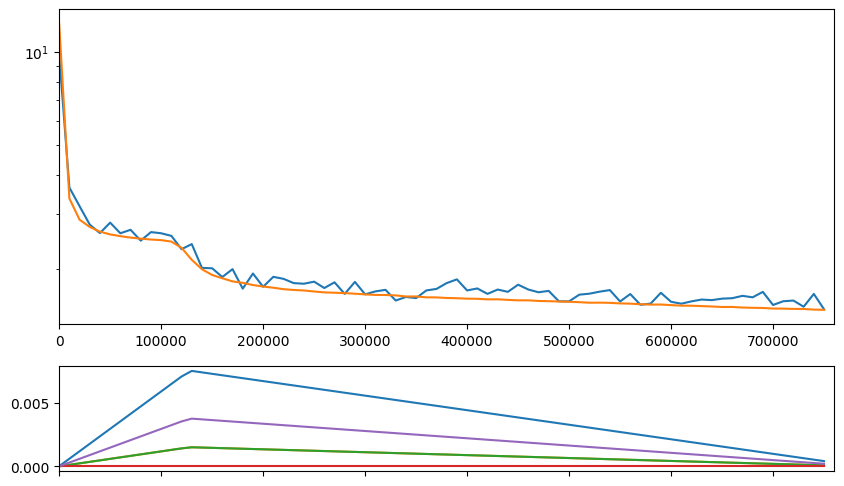

In [ ]:
# baseline
model = make_model('micro', dataset=train_ds, frozen_embeddings_model='vqmodel-medium-en+pl-512c-dim64.model',
                   tunables=Tunables()).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=4,
      warmup_steps=model.tunables.warmup_steps, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=10000)

In [ ]:
model.save_model('t2s-micro.model')

samples,train,val,time
100000,2.44452,2.38181,01:04
200000,2.33279,2.19010,02:11
300000,1.83019,1.82918,03:12
400000,1.74988,1.73074,04:16
500000,1.58686,1.67560,05:15
600000,1.54544,1.62922,06:21
700000,1.68379,1.59513,07:21
759936,1.61915,1.57619,07:57


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


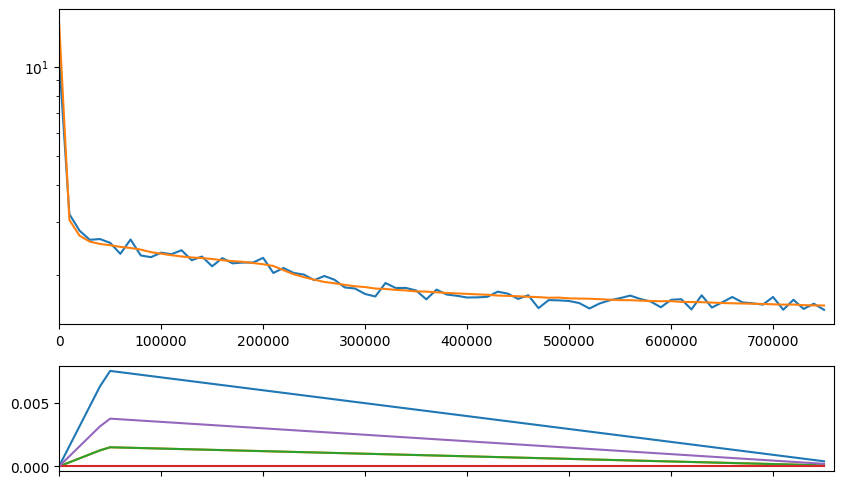

In [ ]:
# no encoder LM loss, trains visibly slower
model = make_model('micro', dataset=train_ds, frozen_embeddings_model='vqmodel-medium-en+pl-512c-dim64.model',
                   tunables=Tunables(causal_encoder=False)).cuda()
train("tsar-wx", model, train_ds, val_ds, half=True, bs=32, lr=model.tunables.lr0, epochs=4,
      warmup_steps=1500, weight_decay=model.tunables.weight_decay, clip_gradient_norm=model.tunables.clip_gradient_norm,
      table_row_every_iters=100000, run_valid_every_iters=10000)